**Instalaciones**

In [ ]:
!pip install imbalanced-learn matplotlib seaborn pandas numpy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

**Importaciones**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE

**Configuración y Carga de Datos**

In [2]:
#Configuración visual
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_palette("husl")
plt.style.use('seaborn-v0_8-whitegrid')

#Directorio de salidas
OUTPUT_DIR = 'outputs_rf'
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_VARIABLE = 'ESTADO_PROGRAMA' #variable objetivo
#Ruta del dataset original
DATA_FILE = '/content/drive/MyDrive/Estudios/UNIR/04. Máster en IA/07. TFE/DATA/data_random_forest/dataset_estudiantes_desercion_randon_forest.csv'
RANDOM_STATE = 42

#Columnas a excluir
COLUMNAS_EXCLUIR_BASE = [
    'ID_ESTUDIANTE', 'DOCUMENTO', 'TIPO_DOCUMENTO', 'FECHA_NACIMIENTO',
    'PERIODO_GRADO_PROGRAMA', 'PERIODO_GRADO_IES', 'PERIODO_GRADO_SISTEMA',
    'RIESGO_ESTRUCTURAL', 'SUPERVIVENCIA', 'SUPERVIVENCIA_ESTRUCTURAL',
    'COHORTE', 'PERIODO_ACADEMICO', 'FRANJA', 'ESTADO_ESTUDIANTE_PERIODO',
    'PROGRAMA_COD', 'CODPROG_MATRICULA', 'ASIGNATURA_COD', 'GRUPO_ASIG'
]

#Agregar las otras variables target para evitar "data leakage"
otras_targets = ['ESTADO_PROGRAMA', 'ESTADO_IES', 'ESTADO_SISTEMA']
COLUMNAS_EXCLUIR_BASE.extend([t for t in otras_targets if t != TARGET_VARIABLE])


df = pd.read_csv(DATA_FILE, sep=';', encoding='latin-1', low_memory=False)

print(f"Dataset cargado: filas, {df.shape[1]} columnas")
print(f"Objetivo: Predecir '{TARGET_VARIABLE}'")

Dataset cargado: filas, 97 columnas
Objetivo: Predecir 'ESTADO_PROGRAMA'


**Preprocesamiento (Limpieza, Imputación y Scaling)**

In [3]:
#Identificar columnas con >70% nulos
nulos_pct = (df.isnull().sum() / len(df) * 100)
cols_alta_nulidad = nulos_pct[nulos_pct > 70].index.tolist()

#Definir columnas finales
cols_a_eliminar = list(set(COLUMNAS_EXCLUIR_BASE + cols_alta_nulidad))
cols_disponibles = [c for c in df.columns if c not in cols_a_eliminar]
df_clean = df[cols_disponibles].copy()

#Limpieza de valores basura, convierte basura a NaN
valores_nulos = ['SIN INFORMACIÓN', 'SIN_INFO', 'nan', 'NaN', 'No aplica', 'NO APLICA']
df_clean.replace(valores_nulos, np.nan, inplace=True)

#Preparación de la variable objetivo
print(f"Filtrando target '{TARGET_VARIABLE}'...")
df_clean = df_clean[df_clean[TARGET_VARIABLE].notna()]

#Aplicación LabelEncoder para multiclase
le = LabelEncoder()
df_clean['TARGET'] = le.fit_transform(df_clean[TARGET_VARIABLE])

print(f"Clases detectadas: {len(le.classes_)}")
print(f"Mapeo de clases: {dict(zip(le.classes_, le.transform(le.classes_)))}")

#Eliminar la columna original del target
if TARGET_VARIABLE in df_clean.columns:
    df_clean.drop(columns=[TARGET_VARIABLE], inplace=True)

#Imputación: mediana para numéricos, moda para categóricos
y = df_clean['TARGET']
X_temp = df_clean.drop(columns=['TARGET'])

cat_cols = X_temp.select_dtypes(include=['object']).columns
num_cols = X_temp.select_dtypes(include=[np.number]).columns

#Imputación numérica
for col in num_cols:
    if X_temp[col].isnull().any():
        X_temp[col] = X_temp[col].fillna(X_temp[col].median())

#imputación categórica
for col in cat_cols:
    if X_temp[col].isnull().any():
        moda = X_temp[col].mode()
        val = moda[0] if len(moda) > 0 else 'SIN_RESPUESTA'
        X_temp[col] = X_temp[col].fillna(val)

#Aplicación de One-Hot Encoding
#Detectar categóricas actuales
columnas_categoricas = X_temp.select_dtypes(include=['object']).columns
columnas_codificar = []

for col in columnas_categoricas:
    if X_temp[col].nunique() <= 15:
        columnas_codificar.append(col)
    else:
        X_temp.drop(columns=[col], inplace=True)

X = pd.get_dummies(X_temp, columns=columnas_codificar, drop_first=True, dtype=int)

y = y.loc[X.index]

#Escalado para SMOTE
scaler = StandardScaler()
cols_num_finales = X.select_dtypes(include=[np.number]).columns
X[cols_num_finales] = scaler.fit_transform(X[cols_num_finales])

feature_names = X.columns.tolist()
print(f"Preprocesamiento listo. Matriz X: {X.shape}")
print(f"Clases en y: {y.unique()}")

Filtrando target 'ESTADO_PROGRAMA'...
Clases detectadas: 3
Mapeo de clases: {'Ausente': np.int64(0), 'Desertor': np.int64(1), 'Graduado': np.int64(2)}
Preprocesamiento listo. Matriz X: (824786, 230)
Clases en y: [0 1 2]


**División y SMOTE (Balanceo)**

In [4]:
#Fragmentación estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Train original: {X_train.shape[0]:,} muestras")
print(f"Distribución original: {y_train.value_counts().to_dict()}")

#Aplicaicón de SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Train Balanceado: {X_train_bal.shape[0]:,} muestras")
print(f"Distribución final: {y_train_bal.value_counts().to_dict()}")

Train original: 659,828 muestras
Distribución original: {2: 267348, 0: 247712, 1: 144768}
Train Balanceado: 802,044 muestras
Distribución final: {0: 267348, 2: 267348, 1: 267348}


**Entrenamiento con GridSearchCV (Random Forest)**

In [5]:
#Configuración de modelo base
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

#Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],      #número de árboles
    'max_depth': [10, 15, 20],       #profundidad máxima
    'min_samples_split': [5],        #simplificado para velocidad
    'min_samples_leaf': [2]
}

#configuración de validación cruzada
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_bal, y_train_bal)
elapsed = time.time() - start_time

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1-Score (Validation): {grid_search.best_score_:.4f}")
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor F1-Score (Validation): 0.9438


**Evaluación y Métricas**


RESULTADOS PARA: ESTADO_PROGRAMA
Accuracy:    0.9398
Macro Recall:0.9423
Macro F1:    0.9331
Macro AUC:   0.9879

Reporte Detallado:
              precision    recall  f1-score   support

     Ausente       0.96      0.92      0.94     61928
    Desertor       0.83      0.96      0.89     36192
    Graduado       1.00      0.95      0.97     66838

    accuracy                           0.94    164958
   macro avg       0.93      0.94      0.93    164958
weighted avg       0.94      0.94      0.94    164958



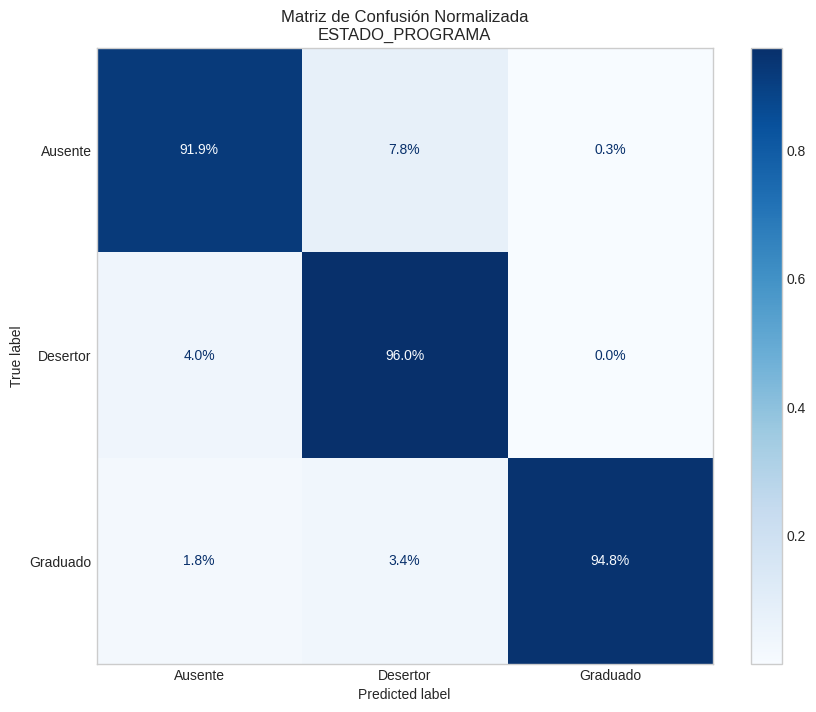

In [7]:
nombres_clases = [str(c) for c in le.classes_]

#Predicciones
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

#Métricas: se usa 'macro' para promediar el rendimiento entre clases
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

#AUC-ROC Multiclase (One-vs-Rest)
try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
except ValueError:
    print("No se pudo calcular AUC (posiblemente falta una clase en el test set).")
    auc = 0.5

print(f"\nRESULTADOS PARA: {TARGET_VARIABLE}")
print("="*40)
print(f"Accuracy:    {acc:.4f}")
print(f"Macro Recall:{rec:.4f}")
print(f"Macro F1:    {f1:.4f}")
print(f"Macro AUC:   {auc:.4f}")
print("="*40)

print("\nReporte Detallado:")
print(classification_report(y_test, y_pred, target_names=nombres_clases))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=nombres_clases,
    cmap='Blues',
    normalize='true',
    values_format=".1%",
    ax=ax
)
ax.set_title(f'Matriz de Confusión Normalizada\n{TARGET_VARIABLE}')
plt.grid(False)
plt.show()

**Visualizaciones (Matriz y ROC)**

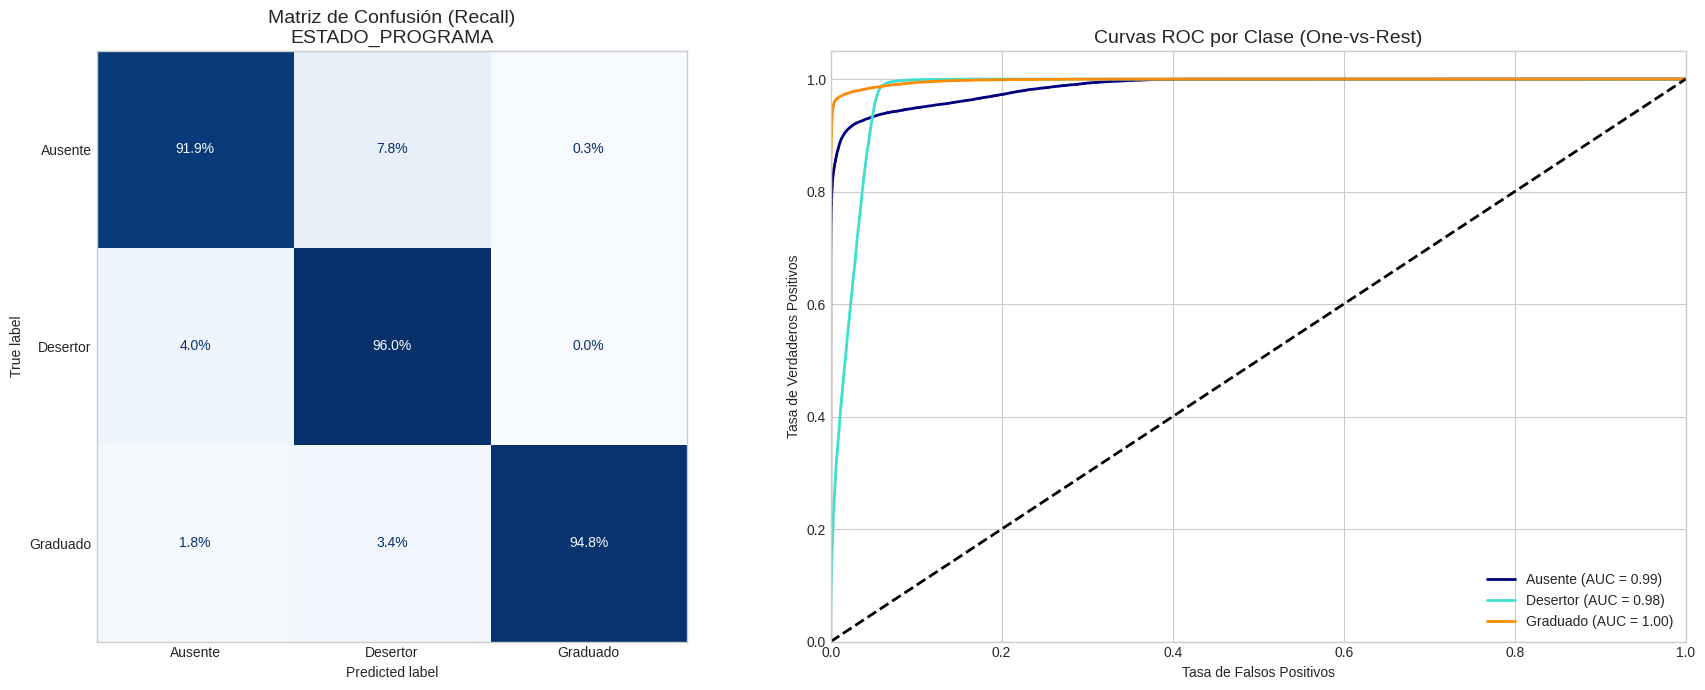

In [8]:
from itertools import cycle

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[str(c) for c in le.classes_],
    cmap='Blues',
    normalize='true',
    values_format=".1%",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title(f'Matriz de Confusión (Recall)\n{TARGET_VARIABLE}', fontsize=14)
axes[0].grid(False)

#grafico de curvas de roc
from sklearn.preprocessing import label_binarize
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])

    class_name = str(le.classes_[i])

    axes[1].plot(
        fpr, tpr,
        color=color,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc:.2f})'
    )

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curvas ROC por Clase (One-vs-Rest)', fontsize=14)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

**Importancia de Variables (Feature Importance)**

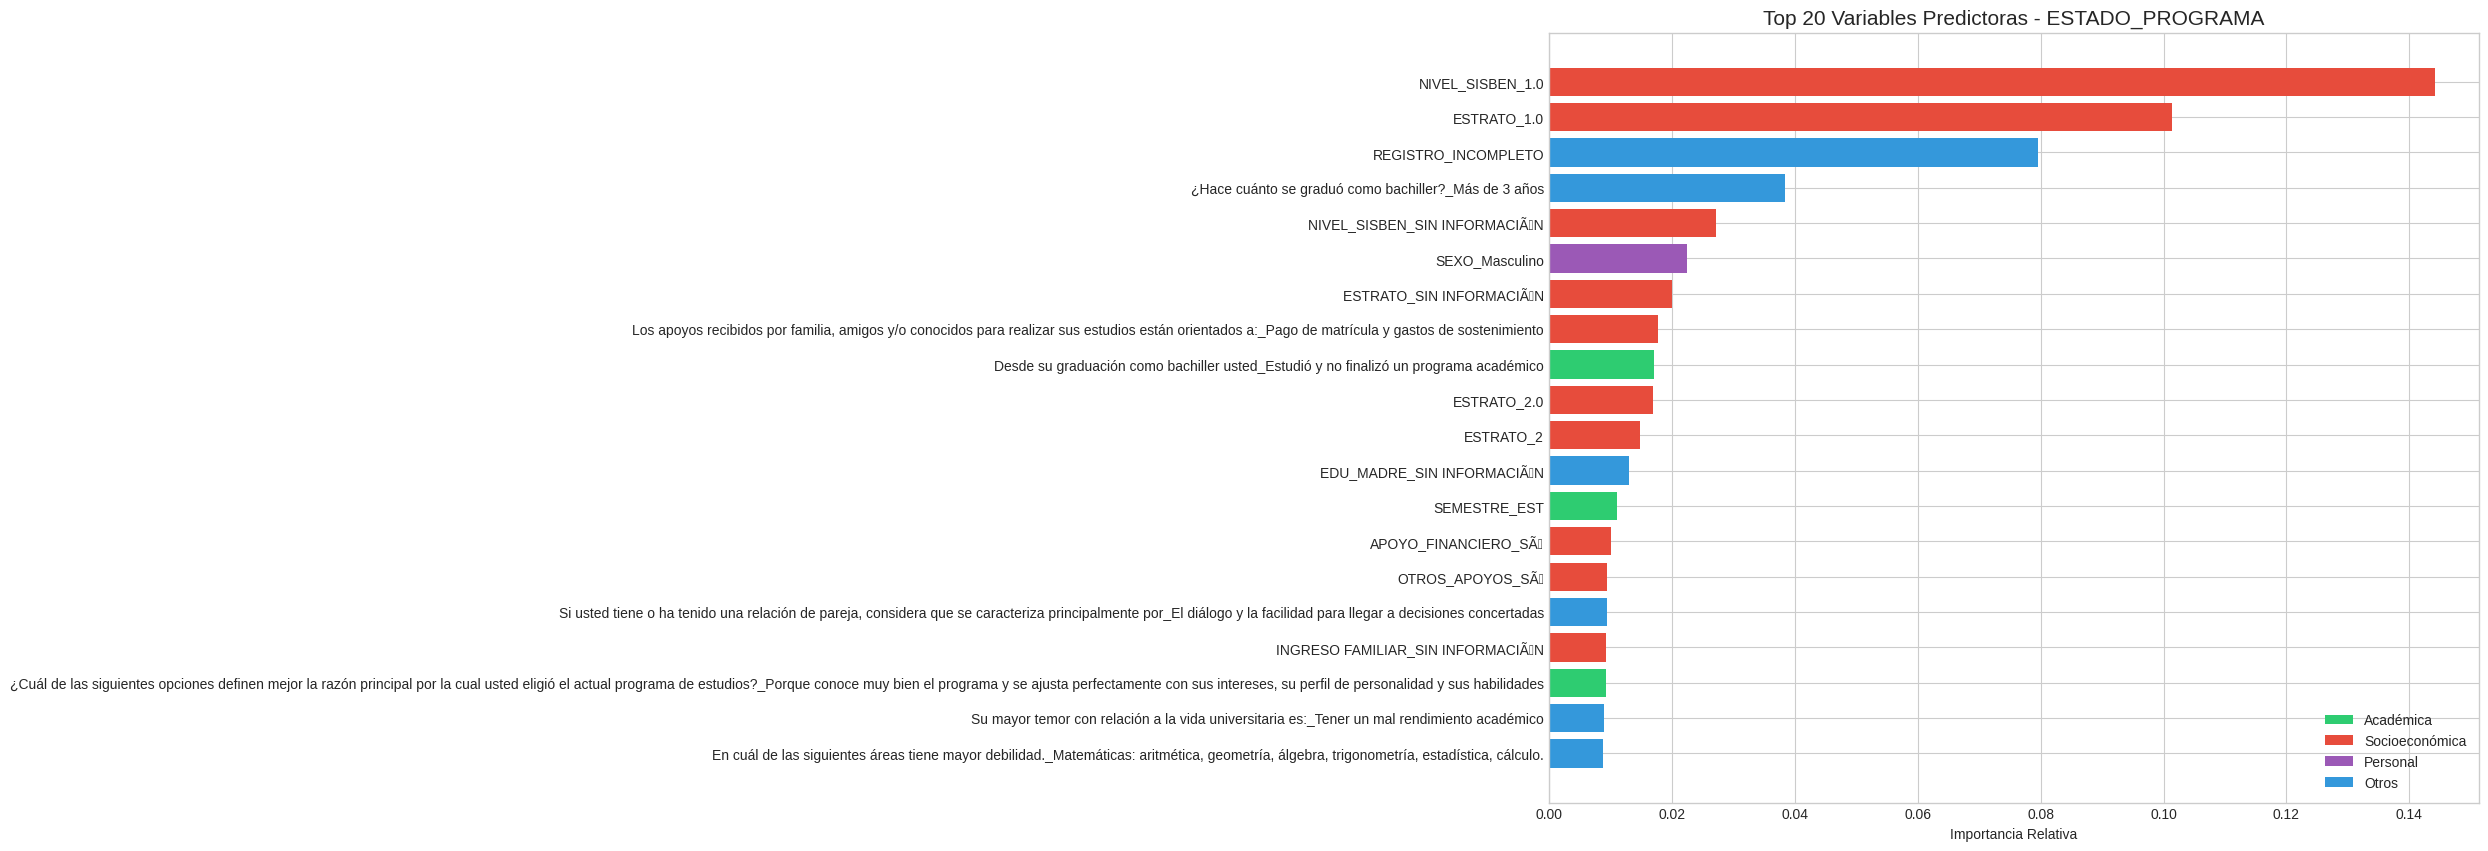

Top 5 Variables más influyentes:
                                              Feature  Importance
32                                   NIVEL_SISBEN_1.0    0.144097
21                                        ESTRATO_1.0    0.101305
9                                 REGISTRO_INCOMPLETO    0.079500
60  ¿Hace cuánto se graduó como bachiller?_Más de ...    0.038389
40                      NIVEL_SISBEN_SIN INFORMACIÃN    0.027127


In [9]:
importances = best_rf.feature_importances_
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values('Importance', ascending=False).head(20)

def get_category_color(name):
    name = name.lower()
    if any(x in name for x in ['nota', 'promedio', 'semestre', 'creditos', 'programa']):
        return '#2ecc71' # Verde (Académico)
    elif any(x in name for x in ['estrato', 'ingreso', 'sisben', 'trabaj', 'apoyo']):
        return '#e74c3c' # Rojo (Socioeconómico)
    elif any(x in name for x in ['edad', 'sexo', 'civil', 'hijos']):
        return '#9b59b6' # Morado (Personal)
    else:
        return '#3498db' # Azul (Otro)

colors = df_imp['Feature'].apply(get_category_color)

#Gráfico
plt.figure(figsize=(12, 10))
bars = plt.barh(df_imp['Feature'], df_imp['Importance'], color=colors)
plt.gca().invert_yaxis() # Mayor importancia arriba
plt.title(f"Top 20 Variables Predictoras - {TARGET_VARIABLE}", fontsize=15)
plt.xlabel("Importancia Relativa")

#Leyenda manual
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Académica'),
    Patch(facecolor='#e74c3c', label='Socioeconómica'),
    Patch(facecolor='#9b59b6', label='Personal'),
    Patch(facecolor='#3498db', label='Otros')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

print("Top 5 Variables más influyentes:")
print(df_imp.head(5)[['Feature', 'Importance']])